Emission Profiles modeled with CHERAB
===

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
from raysect.optical import Point3D, Spectrum, Vector3D, World

from cherab.phix.plasma import import_plasma
from cherab.phix.tools.raytransfer import import_phix_rtc
from cherab.phix.tools.visualize import show_phix_profile, show_phix_profiles

plt.rcParams["figure.dpi"] = 150

In [2]:
world = World()
plasma, eq = import_plasma(world)
rtc = import_phix_rtc(world, equilibrium=eq)
model = [i for i in plasma.models]
print(model)

loading plasma (data from: phix10)...


[<PlasmaModel - Bremsstrahlung>,
 <ExcitationLine: element=hydrogen, charge=0, transition=(3, 2)>,
 <ExcitationLine: element=hydrogen, charge=0, transition=(4, 2)>,
 <ExcitationLine: element=hydrogen, charge=0, transition=(5, 2)>,
 <ExcitationLine: element=hydrogen, charge=0, transition=(6, 2)>,
 <RecombinationLine: element=hydrogen, charge=0, transition=(3, 2)>,
 <RecombinationLine: element=hydrogen, charge=0, transition=(4, 2)>,
 <RecombinationLine: element=hydrogen, charge=0, transition=(5, 2)>,
 <RecombinationLine: element=hydrogen, charge=0, transition=(6, 2)>]

In [3]:
# set sample paramaters
dr = rtc.material.dr
dz = rtc.material.dz
nr = rtc.material.grid_shape[0]
nz = rtc.material.grid_shape[2]
rmin = rtc.material.rmin
zmin = rtc.transform[2, 3]
rmax = rmin + dr * nr
zmax = zmin + dz * nz

xrange = np.linspace(rmin, rmax, nr)
yrange = np.linspace(zmin, zmax, nz)
direction = Vector3D(0, 1, 0)
# H-balmar emission line
Halpha = (655.6, 656.8)
Hbeta = (485.6, 486.5)
Hgamma = (433.6, 434.4)

Bremsstrahlung emission
---

Calculate spectral radiance at $r-z$ plane.

In [4]:
# calculate spectral radiance
spectrum_bins = 500
min_wavelength = 375  # [nm]
max_wavelength = 780
radiance = np.zeros((nr, nz))
spectral_radiance = np.zeros((spectrum_bins, nr, nz))

for i, x in enumerate(xrange):
    for j, y in enumerate(yrange):
        emission = model[0].emission(
            Point3D(x, 0.0, y), direction, Spectrum(min_wavelength, max_wavelength, spectrum_bins)
        )
        spectral_radiance[:, i, j] = emission.samples
        radiance[i, j] = emission.total()

show spacial profile in $r-z$ plane and spectrum at $r=0.33$ line.

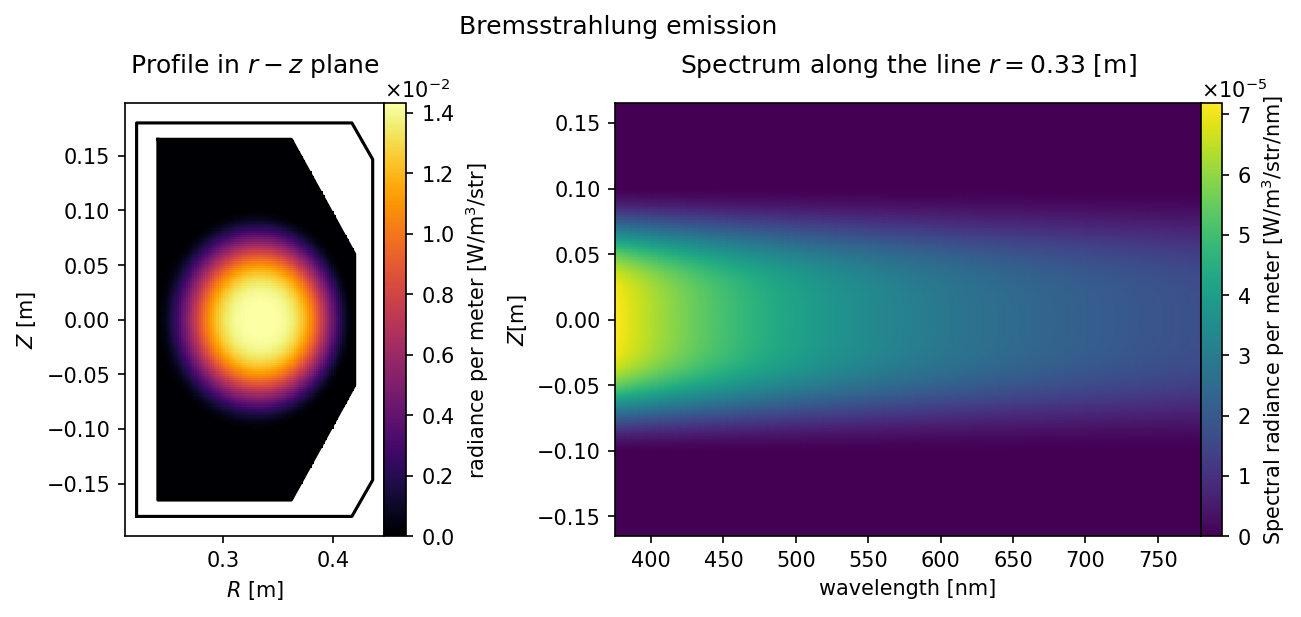

In [7]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))

# show profile
show_phix_profile(axes[0], radiance, cmap="inferno", rtc=rtc, toggle_contour=False)
axes[0].set_title("Profile in $r-z$ plane", pad=15)
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
cbar0 = plt.colorbar(axes[0].collections[0], ax=axes[0], format=fmt, pad=0)
cbar0.set_label("radiance per meter [W/m$^3$/str]")
cbar0.ax.yaxis.set_offset_position("left")
axes[0].set_xlabel("$R$ [m]")
axes[0].set_ylabel("$Z$ [m]")

# show spectrum
r0_index = 46  # index of magnetix axis R in xrange
pc = axes[1].pcolormesh(
    emission.wavelengths,
    yrange,
    spectral_radiance[:, r0_index, :].T,
    shading="gouraud",
)
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
cbar1 = plt.colorbar(
    pc, label="Spectral radiance per meter [W/m$^3$/str/nm]", ax=axes[1], format=fmt, pad=0
)
cbar1.ax.yaxis.set_offset_position("left")
axes[1].set_xlabel("wavelength [nm]")
axes[1].set_ylabel("$Z $[m]")
axes[1].set_title(f"Spectrum along the line $r={xrange[r0_index]:.2f}$ [m]", pad=15)

fig.suptitle("Bremsstrahlung emission", x=0.55);

Plot 1-D bremsstrahlung spectrum at $(r, z) = (0.34, 0)$ which is magnetic axis position.

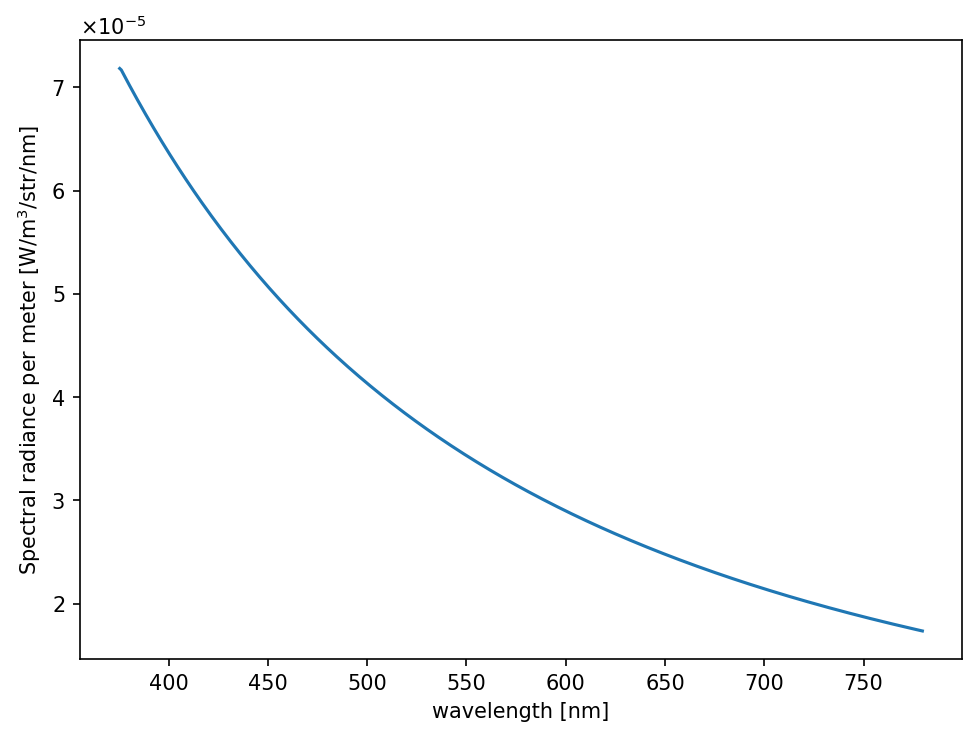

In [8]:
# spectral_radiance index at (r, z) = magnetic axis
idx = np.abs(xrange - eq.magnetic_axis.x).argmin()
idy = np.where(yrange == 0)[0][0]

# plot 1-d spectrum
fig, ax = plt.subplots(1, constrained_layout=True)
ax.plot(emission.wavelengths, spectral_radiance[:, idx, idy])
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("Spectral radiance per meter [W/m$^3$/str/nm]")
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

Excitation emission of hydrogen balmar-series
----

In [9]:
spectrum_bins = 50
radiance = np.zeros((3, nr, nz))
spectral_radiance = np.zeros((3, spectrum_bins, nr, nz))  # number of Hydrogen lines (ax=0)
for i, x in enumerate(xrange):
    for j, y in enumerate(yrange):
        for k, waverange in enumerate([Halpha, Hbeta, Hgamma]):
            emission = model[k + 1].emission(
                Point3D(x, 0.0, y), direction, Spectrum(waverange[0], waverange[1], spectrum_bins)
            )
            spectral_radiance[k, :, i, j] = emission.samples
            radiance[k, i, j] = emission.total()

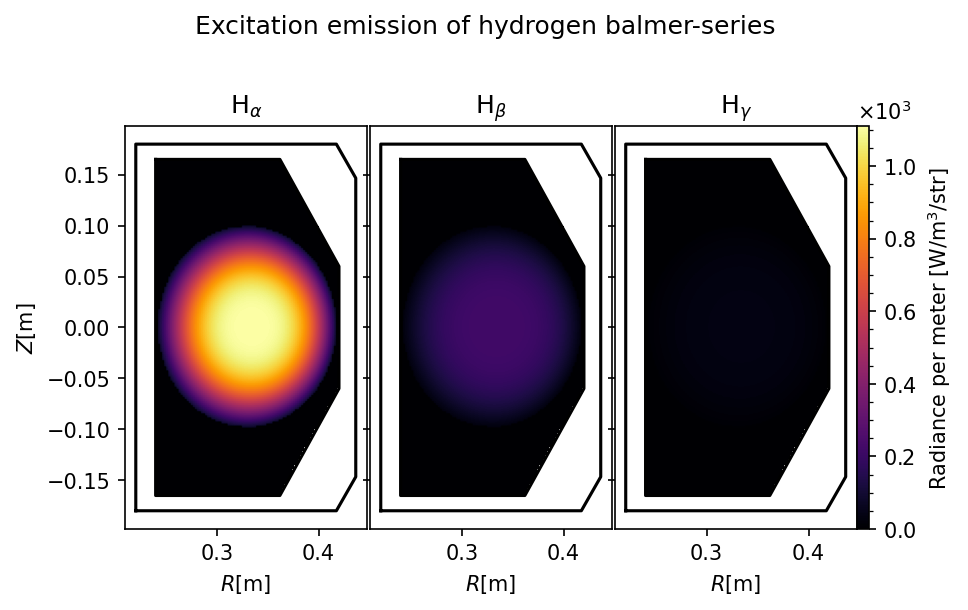

In [10]:
fig, grids = show_phix_profiles(
    [radiance[k, :] for k in range(len(radiance[:, 0, 0]))],
    clabel="Radiance per meter [W/m$^3$/str]",
    cmap="inferno",
    rtc=rtc,
    cbar_mode="single",
    axes_pad=0.02,
)
for grid, name in zip(grids, ["$_\\alpha$", "$_\\beta$", "$_\\gamma$"]):
    grid.set_title(f"H{name}")
fig.suptitle("Excitation emission of hydrogen balmer-series", y=0.93);

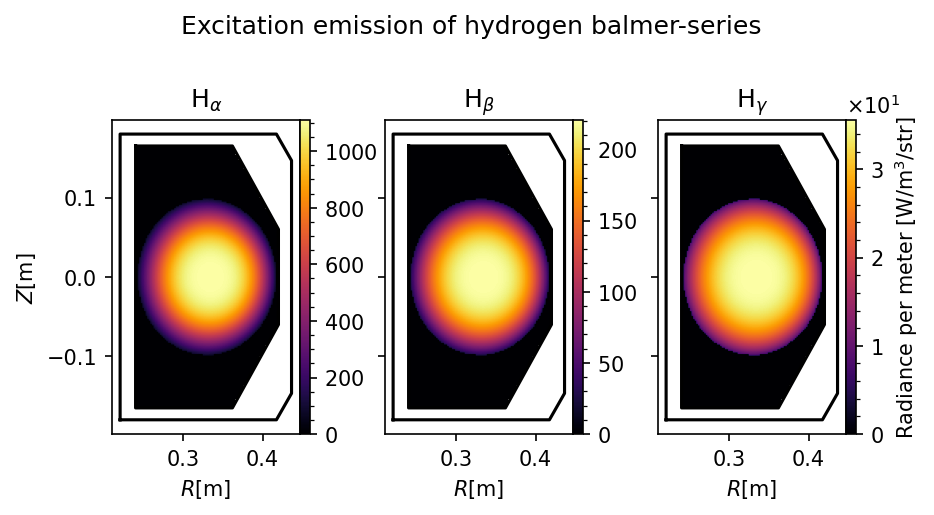

In [11]:
fig, grids = show_phix_profiles(
    [radiance[k, :] for k in range(len(radiance[:, 0, 0]))],
    clabel="Radiance per meter [W/m$^3$/str]",
    cmap="inferno",
    rtc=rtc,
    cbar_mode="each",
    axes_pad=0.5,
)
for grid, name in zip(grids, ["$_\\alpha$", "$_\\beta$", "$_\\gamma$"]):
    grid.set_title(f"H{name}")
fig.suptitle("Excitation emission of hydrogen balmer-series", y=0.86);

Recombination emission of hydrogen balmar-series
----

In [12]:
spectrum_bins = 50
radiance = np.zeros((3, nr, nz))
spectral_radiance = np.zeros((3, spectrum_bins, nr, nz))  # number of Hydrogen lines (ax=0)
for i, x in enumerate(xrange):
    for j, y in enumerate(yrange):
        for k, waverange in enumerate([Halpha, Hbeta, Hgamma]):
            emission = model[k + 5].emission(
                Point3D(x, 0.0, y), direction, Spectrum(waverange[0], waverange[1], spectrum_bins)
            )
            spectral_radiance[k, :, i, j] = emission.samples
            radiance[k, i, j] = emission.total()

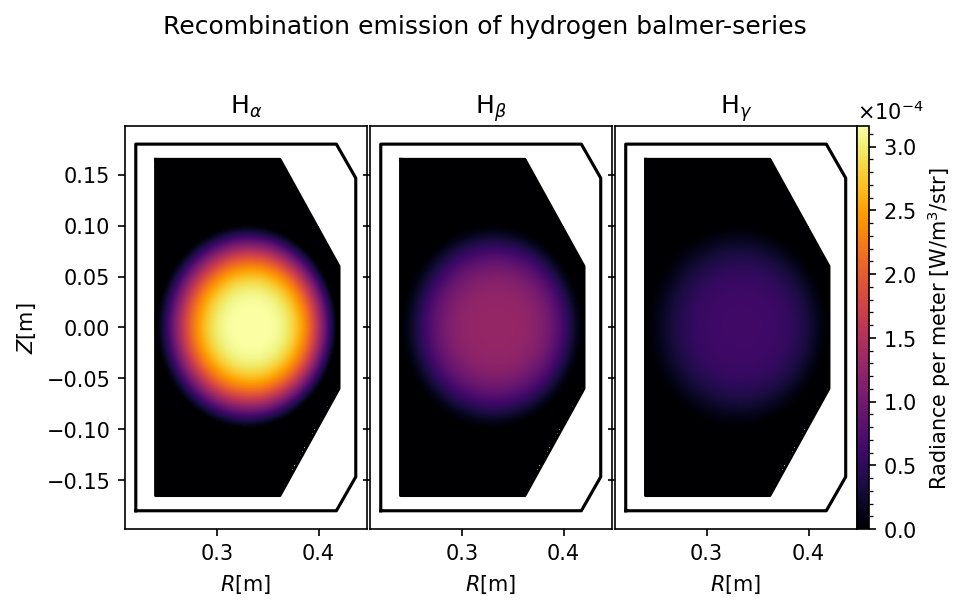

In [13]:
fig, grids = show_phix_profiles(
    [radiance[k, :] for k in range(3)],
    clabel="Radiance per meter [W/m$^3$/str]",
    cmap="inferno",
    rtc=rtc,
    cbar_mode="single",
    scientific_notation=True,
)
for grid, name in zip(grids, ["$_\\alpha$", "$_\\beta$", "$_\\gamma$"]):
    grid.set_title(f"H{name}")
fig.suptitle("Recombination emission of hydrogen balmer-series", y=0.93);

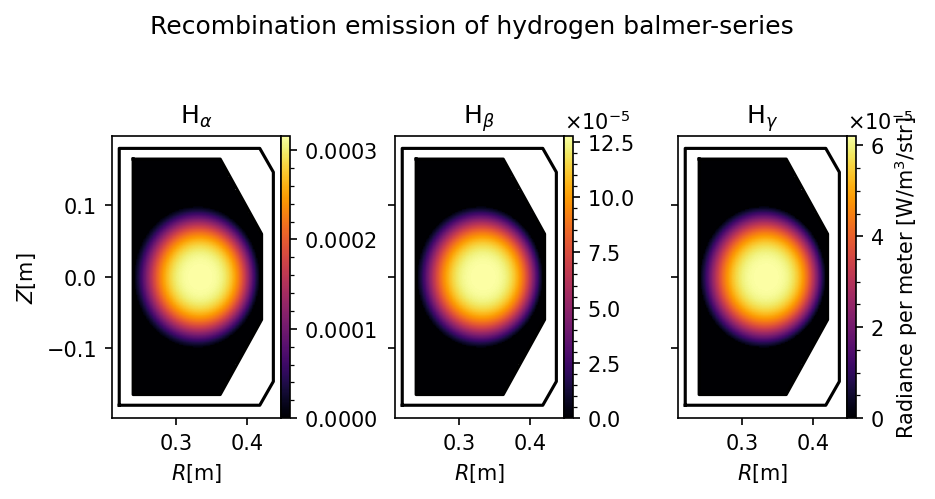

In [14]:
fig, grids = show_phix_profiles(
    [radiance[k, :] for k in range(3)],
    clabel="Radiance per meter [W/m$^3$/str]",
    cmap="inferno",
    rtc=rtc,
    cbar_mode="each",
    scientific_notation=True,
    axes_pad=0.7,
)
for grid, name in zip(grids, ["$_\\alpha$", "$_\\beta$", "$_\\gamma$"]):
    grid.set_title(f"H{name}")
fig.suptitle("Recombination emission of hydrogen balmer-series", y=0.86);

Spectral Radiance per meter at magnetic axis in hydrogen balmar-series
---

In [15]:
spectrum_bins = 50
spectral_radiance_e = np.zeros((3, spectrum_bins))
spectral_radiance_r = np.zeros((3, spectrum_bins))
for k, waverange in enumerate([Halpha, Hbeta, Hgamma]):
    emission_e = model[k + 1].emission(
        Point3D(eq.magnetic_axis.x, 0.0, eq.magnetic_axis.y),
        direction,
        Spectrum(waverange[0], waverange[1], spectrum_bins),
    )
    emission_r = model[k + 5].emission(
        Point3D(eq.magnetic_axis.x, 0.0, eq.magnetic_axis.y),
        direction,
        Spectrum(waverange[0], waverange[1], spectrum_bins),
    )
    spectral_radiance_e[k, :] = emission_e.samples
    spectral_radiance_r[k, :] = emission_r.samples

In [16]:
wavelength = np.concatenate(
    [
        np.linspace(*Hgamma, len(spectral_radiance[2])),
        np.linspace(*Hbeta, len(spectral_radiance[1])),
        np.linspace(*Halpha, len(spectral_radiance[0])),
    ]
)
spectrum_ex = np.concatenate([spectral_radiance_e[i, :] for i in [2, 1, 0]])
spectrum_re = np.concatenate([spectral_radiance_r[i, :] for i in [2, 1, 0]])

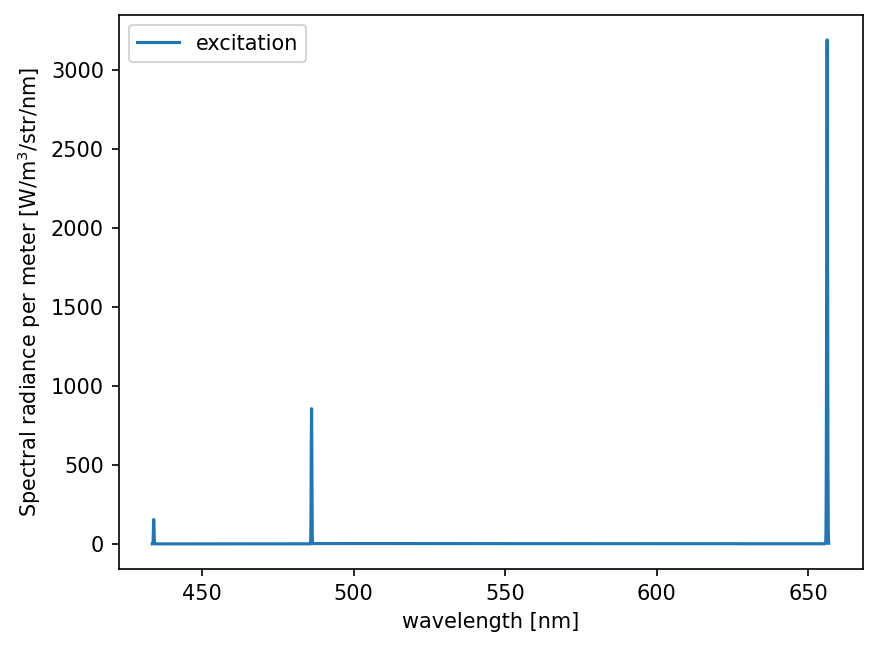

In [17]:
fig, ax = plt.subplots()
ax.plot(wavelength, spectrum_ex, label="excitation")
# ax.plot(wavelength, spectrum_re, label="recombination")
ax.legend()
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("Spectral radiance per meter [W/m$^3$/str/nm]");

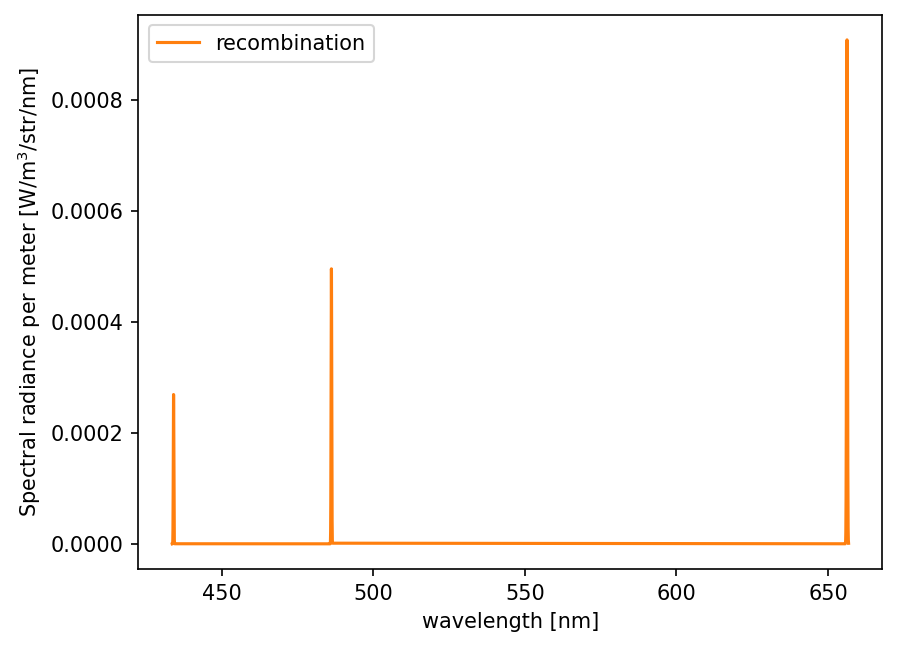

In [18]:
fig, ax = plt.subplots()
# ax.plot(wavelength, spectrum_ex, label="excitation")
ax.plot(wavelength, spectrum_re, label="recombination", color="C1")
ax.legend()
ax.set_xlabel("wavelength [nm]")
ax.set_ylabel("Spectral radiance per meter [W/m$^3$/str/nm]");